# Evolutionary Strategies and Differential Evolution for Neural Network Optimization

In this assignment, we will explore the application of **Evolutionary Strategies (ES) and Differential Evolution (DE)** to optimize the weights of a neural network for solving the **Lunar Lander problem**. The Lunar Lander environment, provided by OpenAI Gym, simulates the challenge of controlling a lunar module to land it safely on a designated landing pad. The task involves applying thrust and rotation to navigate the lander under the influence of gravity while avoiding crashes or drifting out of bounds.

The goal is to train a neural network that acts as a controller for the lander. By optimizing the network weights, the controller learns how to achieve smooth and successful landings. Instead of traditional gradient-based optimization methods, we will use evolutionary algorithms, as introduced in class, to explore the weight space.

In this context, evolutionary algorithms offer a robust and gradient-free optimization approach that is particularly useful for tasks with non-differentiable objectives or high-dimensional search spaces. You will program an ES/DE to optimize the network weights and compare its performance against a **Random Search** baseline, where weights are sampled randomly and evaluated.

The problem at hand is to design an EA that finds a set of neural network weights maximizing the total reward in the Lunar Lander environment. Rewards are given for successful landings and penalized for crashes or inefficient maneuvers. By comparing the EA with Random Search, you will analyze the effectiveness and efficiency of evolutionary optimization methods.


# Assignment Task

In this assignment, you will use Evolutionary Strategies (ES) and Differential Evolution (DE) to optimize the weights of a neural network for the Lunar Lander environment from OpenAI Gym. You will compare the performance of your implementation with a **Random Search** baseline provided in the starter code.

## 0. Setup
Recomended version for setup: python 3.10.16 
Some modules are required to run the code:
```python
python -m pip install gymnasium torch swig matplotlib
python -m pip install "gymnasium[box2d]"
```

## 1. Analyze the provided implementation
- Review the given **Random Search** code. Understand how it generates and evaluates random weight sets for the neural network. Run the code to familiarize yourself with its output and performance.

## 2. Implement the following:
- **2.1 Choose one variant of ES** covered in class, such as CMA-ES, NES.
- **2.2 Implement the selected ES** in Python. Make sure to:
  - Represent the weights of the neural network as the individuals in the population.
  - Design a fitness function based on the reward obtained in the Lunar Lander environment.
  - Include key algorithm mechanisms.

## 3. Run experiments and compare:
Conduct experiments with both the **Random Search** and your EA implementation. For each experiment, run **5 different random seeds** to account for variability. Analyze the following setup:
- **3.1 Your ES implementation vs. Random Search.**

### Metrics to compare:
- **3.3 Best reward achieved**: Compare the highest rewards obtained by each setup.
- **3.4 Convergence speed**: Measure the number of generations required to reach a reward threshold (e.g., a landing reward of 200 or higher).
- **3.5 Consistency**: Report the average and standard deviation of the results across the random seeds.

## 4. Analyze the results:
Report the findings of your experiments in a structured format. Your analysis should include:
- **4.1 Best reward achieved for each setup** (include plots of reward vs. generation for each method).
- **4.2 Average and standard deviation of rewards across runs.**
- **4.3 Convergence speed (generations to reach the threshold) across different setups.**
- **4.4 Observations on the performance improvements (if any) from the enhancements you implemented.**

## 5. Report the best-performing setup:
Summarize the best setup you found for optimizing the Lunar Lander environment, justifying your choice based on your experimental results.

---

### Note:
- As in previous assignments, ensure you run the same setup multiple times with different random seeds to draw reliable conclusions.
- Use the theoretical slides and material discussed in class to support your analysis.

### Further Reading:
- [OpenAI Gym Documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
- Additional material shared in class.

---

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import sys

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.Tanh(),
            #nn.Linear(4, 4),
            #nn.ReLU(),
            nn.Linear(4, output_dim),
        )
    def forward(self, x):
        output = self.model(x)
        return torch.argmax(output).item()
    

In [5]:

class LunarLanderAgent:
    def __init__(self, env_name='LunarLander-v3', search_algorithm=None, episodes=1, time_steps=1000):
        self.env = gym.make("LunarLander-v3", continuous=False, enable_wind=False)
        self.episodes = episodes
        self.time_steps = time_steps
        self.search_algorithm = search_algorithm
        self.input_dim = self.env.observation_space.shape[0]
        self.output_dim = self.env.action_space.n  # Discrete action space
        self.mlp = self.create_mlp(self.input_dim, self.output_dim)
    
    def create_mlp(self, input_dim, output_dim):
        """
        Creates an MLP using PyTorch.
        """
        mlp = MLP(input_dim, output_dim)
        return mlp
    
    def get_param_vector(self):
        params = []
        for param in self.mlp.parameters():
            params.append(param.data.cpu().numpy().flatten())
        return np.concatenate(params)
    
    def set_param_vector(self, vector):
        offset = 0
        for param in self.mlp.parameters():
            shape = param.shape
            size = np.prod(shape)
            param.data = torch.tensor(vector[offset:offset + size].reshape(shape), dtype=torch.float32)
            offset += size
    
    def evaluate(self, vector):
        self.set_param_vector(vector)
        total_reward = 0
        for _ in range(self.episodes):
            obs = self.env.reset()
            episode_reward = 0
            terminated = False
            obs = obs[0]
            i = 0
            while not terminated and i < self.time_steps:
                obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                action = self.mlp(obs)
                #print(action)
                obs, reward, terminated, done, info = self.env.step(action)
                episode_reward += reward
                i += 1
            total_reward += episode_reward
        #print(total_reward)
        return total_reward / self.episodes

    def train(self):
        if self.search_algorithm:
            self.best_params = self.search_algorithm(self)
            self.save_agent("best_agent.pkl")
        else:
            raise ValueError("No search algorithm provided")
        
    def test(self):
        env = gym.make('LunarLander-v3', render_mode="human")
        obs = env.reset()
        total_reward = 0
        terminated = False
        obs = obs[0]
        i = 0
        while not terminated and i < self.time_steps:
            env.render()
            obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = self.mlp(obs)
            obs, reward, terminated, done, info = env.step(action)
            total_reward += reward
            i += 1
        print(f"Test Reward: {total_reward}")
        env.close()
        

    def save_agent(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.get_param_vector(), f)

    def load_agent(self, filename):
        with open(filename, 'rb') as f:
            param_vector = pickle.load(f)
        self.set_param_vector(param_vector)

In [ ]:
def make_evolution_plot(best, mean, title, save=False):
    plt.plot(best, label='Best Overall Reward')
    plt.plot(mean, label='Mean Reward')
    plt.xlabel('Generation')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.draw()
    if save:
        plt.savefig(f'{title}.png')
    plt.pause(0.01)
    plt.clf()


In [ ]:

def random_search(agent, population_size=40, generations=20, alpha=0.01, sigma=0.1):
    """
    Optimize the MLP using Random Search.
    """
    param_vector = agent.get_param_vector()
    num_params = len(param_vector)
    best_params = param_vector
    best_reward = -np.inf
    best_rewards = []
    mean_rewards = []
    for generation in range(generations):
        population = []
        for i in range(population_size):
            ind = param_vector + sigma * np.random.randn(num_params)
            population.append(ind)
        rewards = []
        for individual in population:
            r = agent.evaluate(individual)
            rewards.append(r)
        rewards = np.array(rewards)
        max_reward_idx = np.argmax(rewards)
        if rewards[max_reward_idx] > best_reward:
            best_reward = rewards[max_reward_idx]
            best_params = population[max_reward_idx]
            agent.save_agent(f'best_agent_random_search.pkl')
        # Logging
        print(f"Generation {generation + 1}: Best Overall Reward = {rewards.max()} Mean Reward = {rewards.mean()}")

        best_rewards.append(rewards.max())
        mean_rewards.append(rewards.mean())
    make_evolution_plot(best_rewards, mean_rewards, "RS", True)
    agent.set_param_vector(best_params)
    return best_params

## Train !

Generation 1: Best Reward = -342.3273944125833 Mean Reward = -663.5585746223544
Generation 2: Best Reward = -417.6089855038008 Mean Reward = -620.269210520518
Generation 3: Best Reward = -389.50949676188844 Mean Reward = -632.3748516040964
Generation 4: Best Reward = -461.2152154710582 Mean Reward = -659.0620292918883
Generation 5: Best Reward = -406.1628720697266 Mean Reward = -638.2447908863784
Generation 6: Best Reward = -377.7032738796349 Mean Reward = -603.6959726007151
Generation 7: Best Reward = -491.9364525269955 Mean Reward = -623.2037150210451
Generation 8: Best Reward = -467.2849297574356 Mean Reward = -642.2502755815104
Generation 9: Best Reward = -305.3176938175555 Mean Reward = -623.7867609225186
Generation 10: Best Reward = -408.26510087431535 Mean Reward = -640.9622038937334
Generation 11: Best Reward = -391.4931844961952 Mean Reward = -616.0983961201744
Generation 12: Best Reward = -405.6694216346272 Mean Reward = -650.7347492373312
Generation 13: Best Reward = -475.44

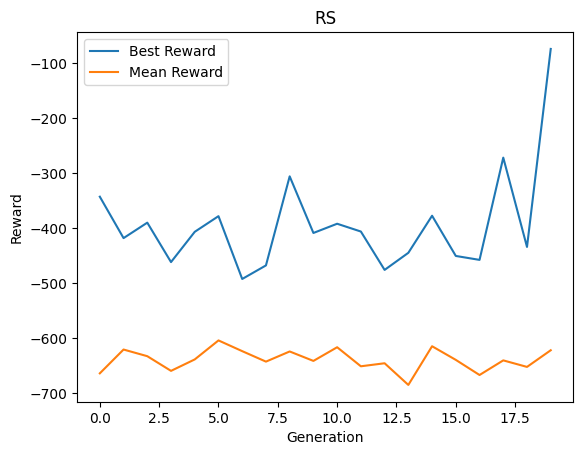

<Figure size 640x480 with 0 Axes>

In [14]:
# Evolve and Train!
np.random.seed(46)
torch.random.manual_seed(46)
agent = LunarLanderAgent(search_algorithm=random_search, episodes=3, time_steps=1000)
agent.train()



## Test ! 

In [ ]:
# Test!
agent = LunarLanderAgent(search_algorithm=random_search, episodes=3, time_steps=1000)
agent.load_agent(f'best_agent_random_search.pkl')
agent.test()


Test Reward: -647.1182312054189


: 